# COVID-19 testing by country (R)

 - Task 1: Get a COVID-19 pandemic Wiki page using HTTP request
 - Task 2: Extract COVID-19 testing data table from the wiki HTML page
 - Task 3: Pre-process and export the extracted data frame
 - Task 4: Get a subset of the extracted data frame
 - Task 5: Calculate worldwide COVID testing positive ratio
 - Task 6: Get a sorted name list of countries that reported their testing data
 - Task 7: Identify country names with a specific pattern
 - Task 8: Pick two countries you are interested in, and then review their testing data
 - Task 9: Compare which one of the selected countries has a larger ratio of confirmed cases to population
 - Task 10: Find countries with confirmedcases to population ratio rate less than a threshold

In [71]:
# Libraries
library(tidyverse)
library(httr2)
library(rvest)

In [72]:
# Set up Jupyter graph display
options(
  repr.plot.width  = 10,
  repr.plot.height = 6,
  repr.plot.res    = 150
)

In [73]:
# Page dl helper
pdl <- function(url, timeout = 10) {
    # The helper downloads the target URL.

    headers <- c(
        "User-Agent" = paste(
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
        "AppleWebKit/537.36 (KHTML, like Gecko)",
        "Chrome/120.0 Safari/537.36"
        ),
        "Accept" = "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language" = "en-GB,en;q=0.9",

        "Accept-Encoding" = "gzip, deflate, br",
        "DNT" = "1",
        "Connection" = "keep-alive",
        "Upgrade-Insecure-Requests" = "1",
        "Referer" = "https://www.google.com/"
    )

    req <- request(url) |>
        req_headers(!!!as.list(headers)) |> # Splice the elements into arguments with tidy !!!
        req_timeout(timeout)

    resp <- tryCatch(
        req_perform(req),
        error = function(e) {
        message("Page not downloaded:\nURL: ", url, " (", conditionMessage(e), ")")
        return(NULL)
        }   
    )

    status <- resp_status(resp)

    if (is.null(resp) || status < 200L || status >= 300L) {
        message("Page not downloaded:\nURL: ", url, "(", status, ")")
        return(NULL)
    }

    return(resp)
}

# Persistent dl helper
pdlf <- function(timeout = 10) {
    # The helper downloads the target URL within a persistent session.
    # Assingn pdlf() to ppdl and call ppdl() on urls within a loop

    headers <- c(
        "User-Agent" = paste(
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
            "AppleWebKit/537.36 (KHTML, like Gecko)",
            "Chrome/120.0 Safari/537.36"
        ),
        "Accept" = "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language" = "en-GB,en;q=0.9"
    )

    h <- curl::new_handle()

    function(url) {
        req <- request(url) |>
            req_headers(!!!as.list(headers)) |>
            req_timeout(timeout) |>
            req_options(handle = h)

    status <- resp_status(resp)

    resp <- tryCatch(req_perform(req), error = function(e) NULL)
    if (is.null(resp) || status < 200L || status >= 300L) return(NULL)

    return(resp)
  }
}

## Tasks 1 through 4

In [74]:
# URL
    # Template page
url1 <- r"(https://en.wikipedia.org/w/index.php?title=Template:COVID-19_testing_by_country)"
    # Current page
url2 <- r"(https://en.wikipedia.org/wiki/COVID-19_testing)"

Direct download. (Avoid repeated downloads lest you get caught out.)

```R
# Download the page
wiki_page <- pdl(url2) 

# Extract the tab
tab <- wiki_page |>
    resp_body_string() |>
    read_html() |>
    html_table()

df <- tab[[3]]

df |>
    head()
```

In [75]:
# Load up the local file
wiki_page <- readLines("data/m5_covid-19.html", warn = FALSE) |>
    paste(collapse = "\n")

In [76]:
# Extract the table
tab <- wiki_page |>
    read_html() |>
    html_table()

df <- tab[[3]]

df |>
    head()

Country or region,Date[a],Tested,Units[b],Confirmed(cases),"Confirmed /tested,%","Tested /population,%","Confirmed /population,%",Ref.
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Afghanistan,17 Dec 2020,"154,767",samples,"49,621",32.1,0.40,0.13,[248]
Albania,18 Feb 2021,"428,654",samples,"96,838",22.6,15.0,3.4,[249]
Algeria,2 Nov 2020,"230,553",samples,"58,574",25.4,0.53,0.13,[250][251]
Andorra,23 Feb 2022,"300,307",samples,"37,958",12.6,387,49.0,[252]
Angola,2 Feb 2021,"399,228",samples,"20,981",5.3,1.3,0.067,[253]
Antigua and Barbuda,6 Mar 2021,"15,268",samples,832,5.4,15.9,0.86,[254]


In [77]:
# Clean-up
df <- df |>
    # Clean col names
    janitor::clean_names() |>
    rename(date = date_a) |>
    rename(units = units_b)

In [78]:
df <- df |>
    # Format dates
    mutate(
        date = if_else(nchar(date) > nchar("dd bbb yyyy"), NA, date),
        date = parse_date_time(date, orders = "d b Y", quiet = TRUE)
    ) |>
    # Filter out footnotes
    filter(!is.na(date)) |>
    # Format numeric cols
    mutate(
        across(
            .cols = c(
                colnames(df)[str_detect(colnames(df), "tested")],
                colnames(df)[str_detect(colnames(df), "confirmed")]
            ),
            .fns = ~ as.numeric(str_replace_all(.x, ",", ""))
        )
    ) |>
    # Clean up entity names
    mutate(
        country_or_region = str_replace_all(country_or_region, "\\[.*?\\]", "")
    )

df |>
    sample_n(10)

country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
<chr>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Greece,2022-12-18,101576831,samples,5548487,5.5,943.0,51.50,[317]
Argentina,2022-04-16,35716069,samples,9060495,25.4,78.3,20.00,[255]
Bulgaria,2023-02-02,10993239,samples,1295524,11.8,158.0,18.60,[277]
Turkey,2021-07-02,61236294,samples,5435831,8.9,73.6,6.50,[426]
Faroe Islands,2022-02-27,774000,samples,34237,4.4,1493.0,65.70,[307]
Saint Kitts and Nevis,2021-08-26,30231,cases,995,3.3,57.6,1.90,[399]
Palestine,2022-02-05,3078533,samples,574105,18.6,60.9,11.40,[385]
Pakistan,2021-03-05,9173593,samples,588728,6.4,4.2,0.27,[384]
Slovakia,2023-02-02,7391882,samples,1861034,25.2,135.0,34.10,[408]


In [79]:
# Dimension check
d <- dim(df)

sprintf("%d rows and %d cols.", d[1], d[2])

[1] "172 rows and 9 cols."

## Task 5: Calculate worldwide COVID testing positive ratio

### Global ratio

In [80]:
# Global confirmed/tested ratio
confirmed_tested <- sum(df["confirmed_cases"]) / sum(df["tested"])

cat("Percentage of all tested confirmed positive:\n", round(confirmed_tested * 100, 2))

Percentage of all tested confirmed positive:
 7.99

### Country-specific ratios

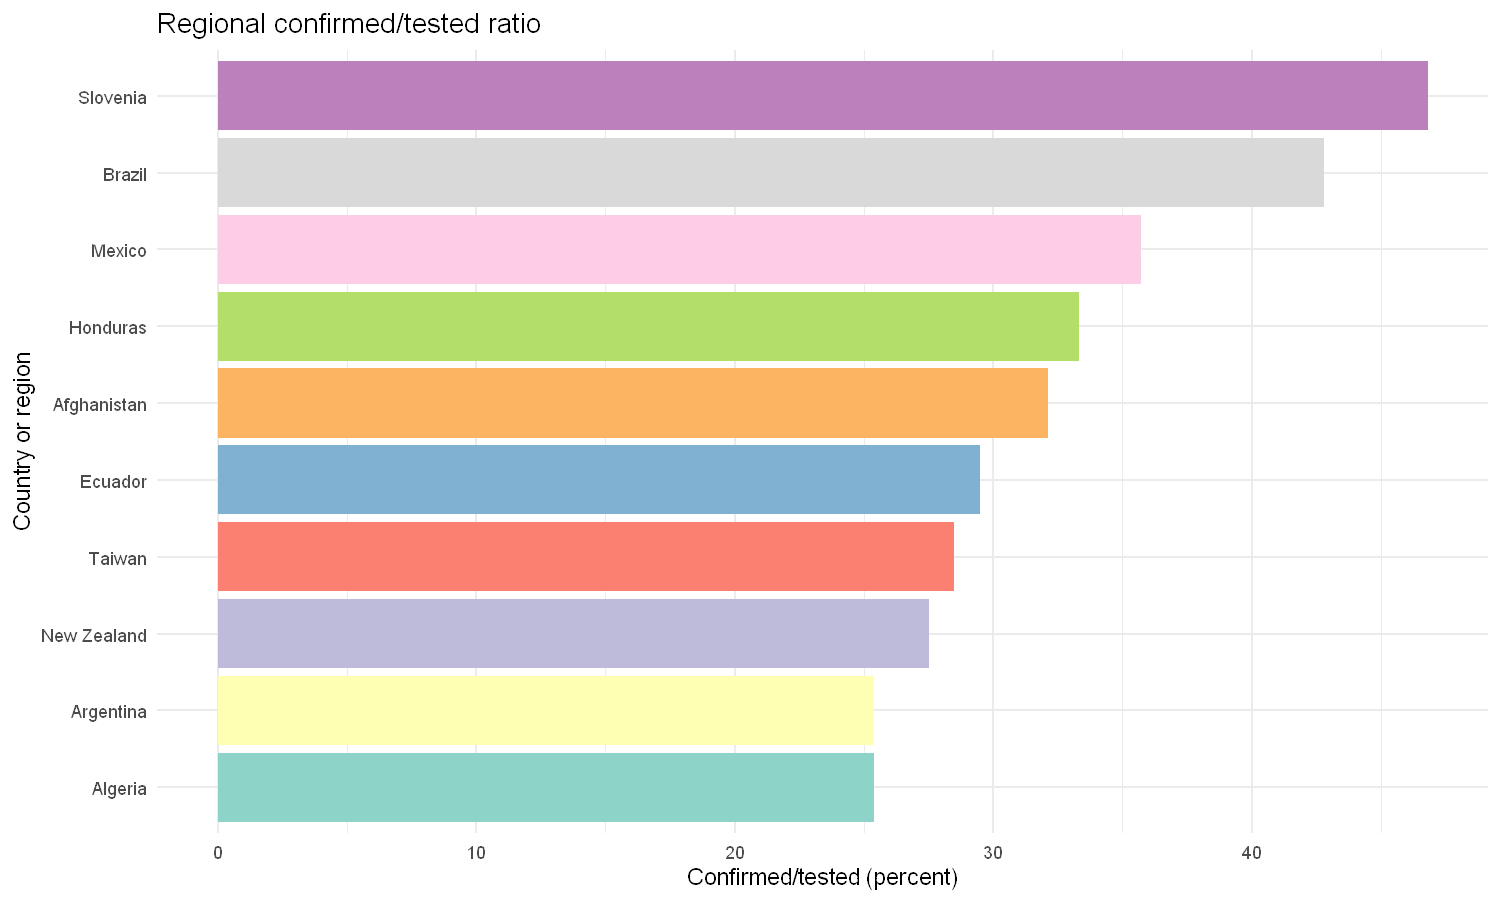

In [81]:
# Top 10 confirmed/tested ratio per country
gg_df1 <- df |>
    arrange(desc(confirmed_tested_percent)) |>
    slice(seq(10)) |>
    # Construct a factor for ggplot
    mutate(
        country_or_region = fct_reorder(country_or_region, confirmed_tested_percent)
    )

ggplot(gg_df1, aes(x = country_or_region, y = confirmed_tested_percent, fill = country_or_region)) +
    geom_bar(stat = "identity") + 
    coord_flip() + 
    theme_minimal() +
        # Bar colour w/ fill arg in aes()
    #scale_fill_manual(values = c("#FF0000", "#00FF00", "#0000FF")) +
    scale_fill_brewer(palette = "Set3") +  # palette = c("Paired", "Spectral")
    #scale_fill_viridis_d() + # Continuous scale
    labs(
        title = "Regional confirmed/tested ratio",
        x = "Country or region", 
        y = "Confirmed/tested (percent)"
    ) +
    theme(legend.position = "none")

## Task 6: Get a sorted name list of countries that reported their testing data

In [82]:
# Sort the df alphabetically in the descending order
df |>
    arrange(desc(country_or_region)) |>
    head()

country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
<chr>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Zimbabwe,2022-10-15,2529087,samples,257893,10.2,17.0,1.70,[250][438]
Zambia,2022-03-10,3301860,samples,314850,9.5,19.0,1.80,[437]
Vietnam,2022-08-28,45772571,samples,11403302,24.9,46.4,11.60,[436]
Venezuela,2021-03-30,3179074,samples,159149,5.0,11.0,0.55,[435]
Uzbekistan,2020-09-07,2630000,samples,43975,1.7,7.7,0.13,[434]
Uruguay,2022-04-16,6089116,samples,895592,14.7,175.0,25.80,[433]


## Task 7: Identify countries names with a specific pattern

In [83]:
# Find every united entity
united_df <- df |>
    filter(str_detect(str_to_lower(country_or_region), "united"))

united_df

country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
<chr>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
United Arab Emirates,2023-02-01,198685717,samples,1049537,0.53,2070,10.9,[429]
United Kingdom,2022-05-19,522526476,samples,22232377,4.30,774,32.9,[430]
United States,2022-07-29,929349291,samples,90749469,9.80,281,27.4,[431][432]


## Task 8: Pick two countries you are interested, and then review their testing data

In [84]:
# Subset the df to compare two countries
select_countries <- c("Venezuela", "Greenland")

c1 <- df[df[["country_or_region"]] == select_countries[1], ]
c2 <- df[df[["country_or_region"]] == select_countries[2], ]

bind_rows(c1,c2)

country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
<chr>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Venezuela,2021-03-30,3179074,samples,159149,5.0,11,0.55,[435]
Greenland,2022-01-30,164573,samples,10662,6.5,293,19.00,[318]


## Task 9: Compare which one of the selected countries has a larger ratio of confirmed cases to population

In [85]:
# Use a conditional statement to identify the country with the higher confirmed/tested ratio
if (c1$confirmed_population_percent > c2$confirmed_population_percent) {
   country <- c1$country_or_region
   ratio <- c1$confirmed_population_percent
} else {
   country <- c2$country_or_region
   ratio <- c2$confirmed_population_percent
}

cat(country, "has a higher ratio of confirmed cases per head, viz.", ratio, "%.")

Greenland has a higher ratio of confirmed cases per head, viz. 19 %.

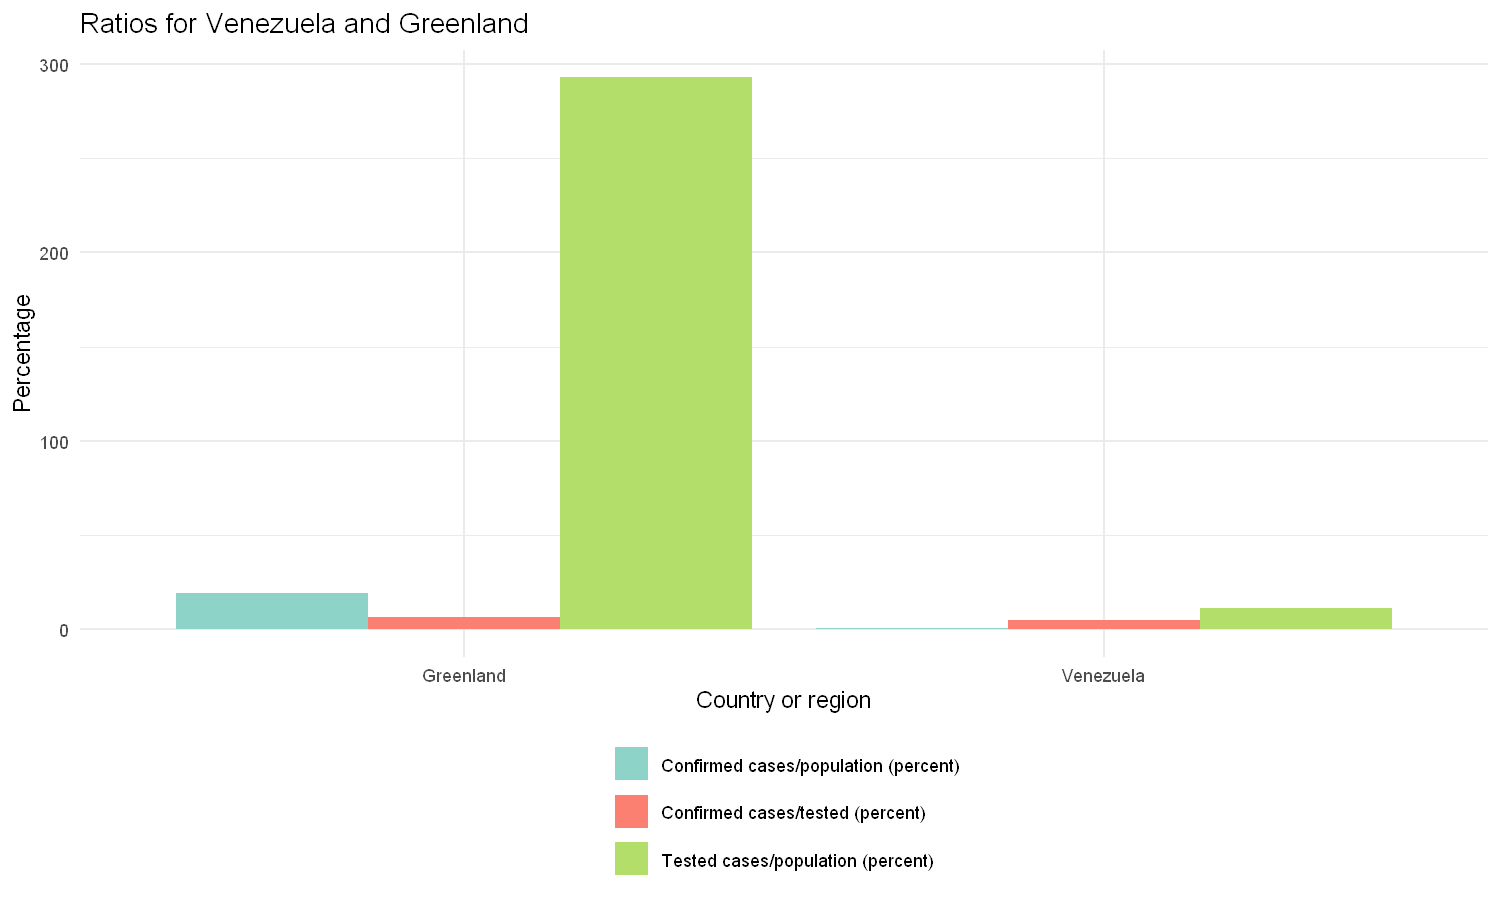

In [86]:
# Select the same countries the tidy way and pivot for ggplot
my_colours <- RColorBrewer::brewer.pal(12, "Set3")[c(1, 4, 7)]

gg_df2 <- df |>
    filter(country_or_region %in% select_countries) |>
    select(country_or_region, ends_with("percent")) |>
    pivot_longer(
        cols = -country_or_region,
        names_to = "var",
        values_to = "val"
    ) |>
    mutate(
        var = factor(
            var, 
            levels = c(
                        "confirmed_population_percent",
                        "confirmed_tested_percent",
                        "tested_population_percent"
                    )
            )
    )

# Plot the percentages    
ggplot(gg_df2, aes(fill = var, y = val, x = country_or_region)) + 
    geom_bar(position="dodge", stat="identity") + 
    theme_minimal() +
    theme(legend.position = "bottom") +
    labs(
        title=paste0("Ratios for ", select_countries[1], " and ", select_countries[2]),
        x="Country or region", 
        y="Percentage",
        fill=""
    ) +
    scale_fill_manual(
        # palette = "Set3", # w/ scale_fill_brewer()
        values = my_colours,
        labels=list(
            confirmed_population_percent = "Confirmed cases/population (percent)",
            confirmed_tested_percent = "Confirmed cases/tested (percent)",
            tested_population_percent = "Tested cases/population (percent)"
        )
    ) +
    guides(fill = guide_legend(nrow = 3))

## Task 10: Find countries with confirmed to population ratio rate less than a threshold

In [87]:
# Get a subset of any countries with confirmed/population ratio less than the threshold
df |>
    filter(confirmed_population_percent < 0.01)

country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
<chr>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Burundi,2021-01-05,90019,,884,0.980,0.7600,0.00740,[279]
China,2020-07-31,160000000,cases,87655,0.055,11.1000,0.00610,[284][285]
Laos,2021-03-01,114030,cases,45,0.039,1.6000,0.00063,[344]
North Korea,2020-11-25,16914,cases,0,0.000,0.0660,0.00000,[378]
Tanzania,2020-11-18,3880,,509,13.100,0.0065,0.00085,[250]
